<a href="https://www.kaggle.com/code/ataturhan/titanic-predicting-survivors?scriptVersionId=208520991" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Task 0: Introduction

Welcome to the Titanic Survival Prediction notebook! This notebook tackles the classic Kaggle Titanic Challenge, where the goal is to predict the survival of passengers based on their demographic and socio-economic attributes. Leveraging powerful machine learning models such as Logistic Regression, RandomForest, XGBoost, and Stacked Ensembles, we combine robust feature engineering and advanced interpretability techniques like SHAP values, permutation importance, and feature importances to gain insights into model predictions. By the end of this notebook, we aim to not only achieve strong predictive performance but also understand the "why" behind the predictions, making the models both accurate and explainable. 🚢✨

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.ensemble import StackingClassifier
from sklearn.inspection import permutation_importance
import shap

# Setting visual styles
plt.style.use('ggplot')
sns.set_context('notebook')
shap.initjs()

In [3]:
HO_TUNING = False
LOAD_MODEL = True
if not os.path.exists("/kaggle/working/models/"):
    os.mkdir("/kaggle/working/models/") 

# Task 1: Data Loading and Exploration

In [4]:
# Step 2: Loading the dataset
# Load both the training and testing datasets
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

# Display basic information about the training set
print("Training Set Information:")
train_df.info()

# Display basic information about the test set
print("\nTest Set Information:")
test_df.info()

Training Set Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Test Set Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   P

In [5]:
# Step 3: Basic statistics and initial data exploration
# Display first few rows of the training set
print("\nFirst 5 rows of the training set:")
print(train_df.head())

# Check for missing values in the training and test set
print("\nMissing values in the training set:")
print(train_df.isnull().sum())

print("\nMissing values in the test set:")
print(test_df.isnull().sum())


First 5 rows of the training set:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            

# Task 2: Exploratory Data Analysis (EDA)

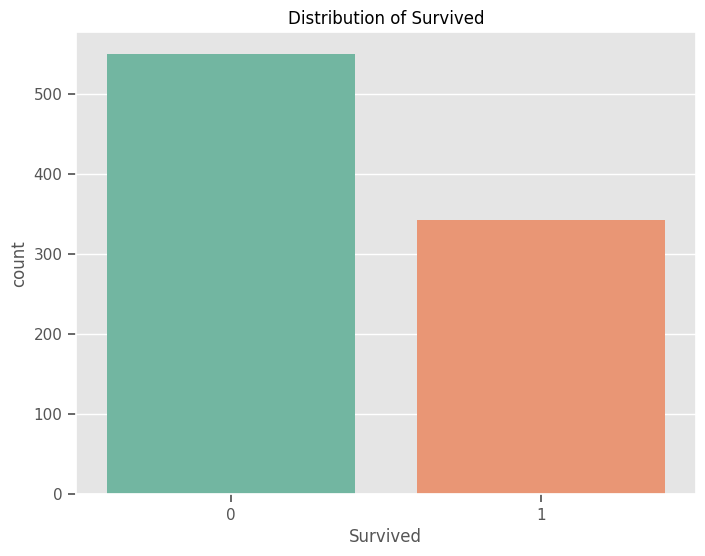

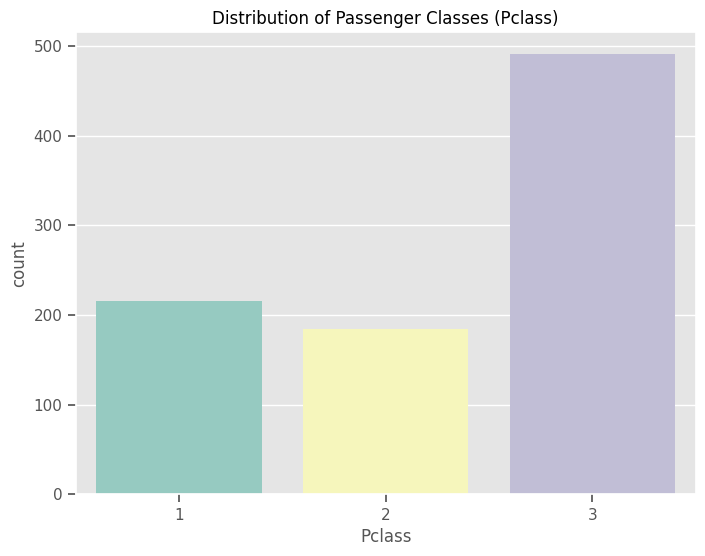

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


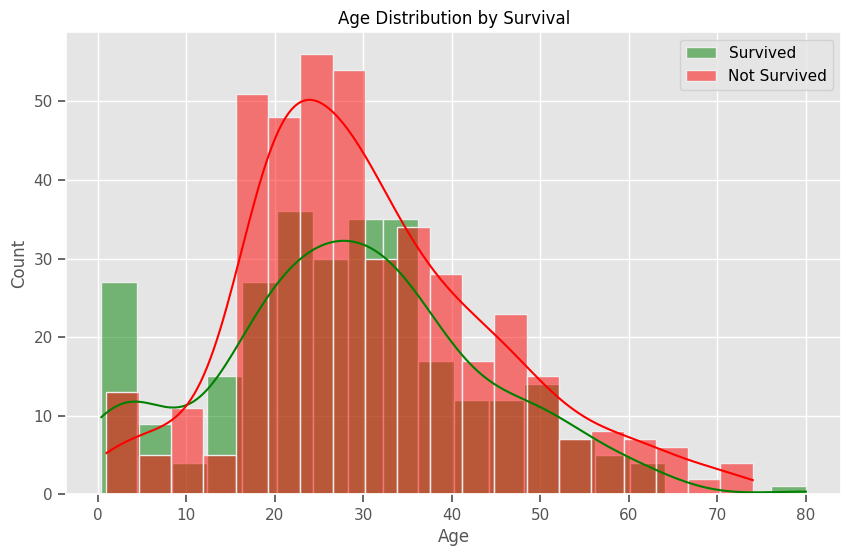

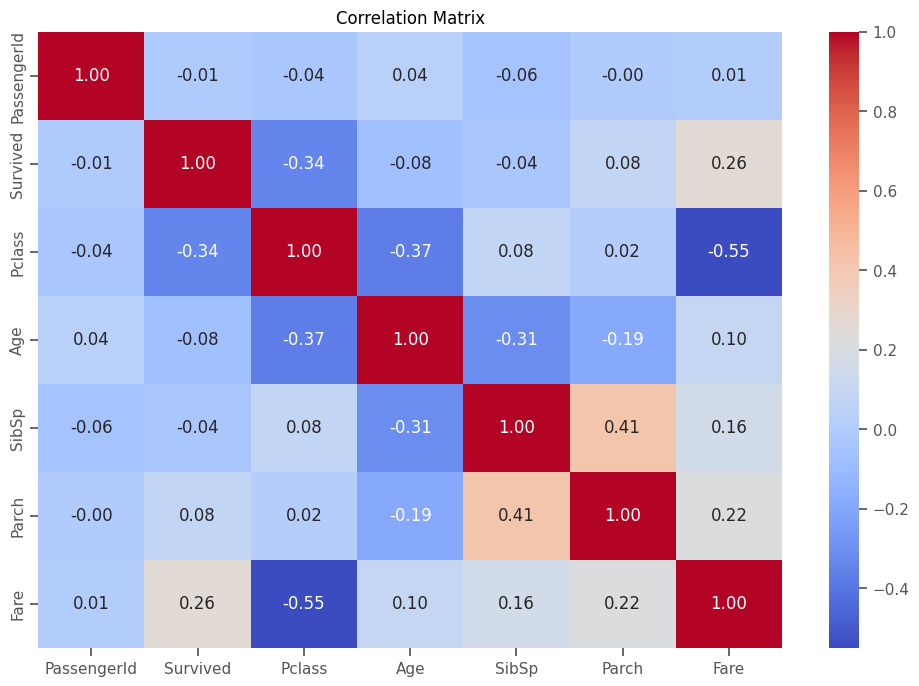

In [6]:
# Step 4: Exploratory Data Analysis (EDA)
# Visualize distribution of 'Survived' feature in the training set
plt.figure(figsize=(8,6))
sns.countplot(data=train_df, x='Survived', palette='Set2')
plt.title('Distribution of Survived')
plt.show()

# Visualize class distribution (Pclass)
plt.figure(figsize=(8,6))
sns.countplot(data=train_df, x='Pclass', palette='Set3')
plt.title('Distribution of Passenger Classes (Pclass)')
plt.show()

# Distribution of age with respect to survival
plt.figure(figsize=(10,6))
sns.histplot(train_df[train_df['Survived'] == 1]['Age'].dropna(), bins=20, color='green', label='Survived', kde=True)
sns.histplot(train_df[train_df['Survived'] == 0]['Age'].dropna(), bins=20, color='red', label='Not Survived', kde=True)
plt.title('Age Distribution by Survival')
plt.legend()
plt.show()

# Correlation matrix to check relationships between numerical variables
# Filter only numeric columns
numeric_features = train_df.select_dtypes(include=[np.number])

plt.figure(figsize=(12,8))
sns.heatmap(numeric_features.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Task 3: Data Preprocessing

In [7]:
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

In [8]:
# Step 1: Handling missing values

# Filling missing 'Age' with the median of the corresponding 'Pclass' group
train_df['Age'] = train_df.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.median()))
test_df['Age'] = test_df.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.median()))

# Add AgeGroup feature
for df in [train_df, test_df]:
    df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 80], labels=[0, 1, 2, 3, 4])


# Filling missing 'Embarked' with the most common value (mode)
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)

# Filling missing 'Fare' in the test set with the median of the corresponding 'Pclass'
test_df['Fare'] = test_df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))

# Add FareBin feature
for df in [train_df, test_df]:
    df['FareBin'] = pd.qcut(df['Fare'], 4, labels=[0, 1, 2, 3])


# Step 2: Feature engineering

# Add Age*Pclass interaction feature
for df in [train_df, test_df]:
    df['Age*Pclass'] = df['AgeGroup'].astype(int) * df['Pclass']


# Creating a new feature 'FamilySize' by combining 'SibSp' (siblings/spouses) and 'Parch' (parents/children)
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

# Creating a new feature 'IsAlone': if the passenger is traveling alone or with family
train_df['IsAlone'] = 1  # Default value for alone
train_df['IsAlone'].loc[train_df['FamilySize'] > 1] = 0  # Not alone if FamilySize > 1
test_df['IsAlone'] = 1
test_df['IsAlone'].loc[test_df['FamilySize'] > 1] = 0

# Extracting 'Title' from 'Name' to use it as a feature
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Simplifying 'Title' by replacing rare titles with 'Rare'
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
train_df['Title'] = train_df['Title'].replace(rare_titles, 'Rare')
test_df['Title'] = test_df['Title'].replace(rare_titles, 'Rare')

# Grouping less common titles into 'Miss', 'Mrs', 'Mr', 'Master', and 'Rare'
train_df['Title'] = train_df['Title'].replace(['Mlle', 'Ms'], 'Miss')
train_df['Title'] = train_df['Title'].replace('Mme', 'Mrs')
test_df['Title'] = test_df['Title'].replace(['Mlle', 'Ms'], 'Miss')
test_df['Title'] = test_df['Title'].replace('Mme', 'Mrs')

# Step 3: Encoding categorical variables

# Create FamilySurvival indicator based on FamilySize and Survival rate
family_survival_rate = train_df.groupby('FamilySize')['Survived'].mean().to_dict()

# Apply FamilySurvival to both train and test dataframes
for df in [train_df, test_df]:
    df['FamilySurvival'] = df['FamilySize'].map(family_survival_rate)
    df['FamilySurvival'] = df['FamilySurvival'].fillna(0)  # Default to 0 if unknown family size


# Mapping 'Sex' to numerical values
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})
test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})

# Mapping 'Embarked' to numerical values
train_df['Embarked'] = train_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
test_df['Embarked'] = test_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Encoding 'Title' as categorical
title_mapping = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4}
train_df['Title'] = train_df['Title'].map(title_mapping)
test_df['Title'] = test_df['Title'].map(title_mapping)

# Extract Deck feature from Cabin information
for df in [train_df, test_df]:
    df['Deck'] = df['Cabin'].str[0]  # Take the first letter as Deck
    df['Deck'] = df['Deck'].fillna('M')  # Assign 'M' for missing values

# Map 'Deck' to numeric categories
deck_mapping = {deck: idx for idx, deck in enumerate(sorted(train_df['Deck'].unique()))}
train_df['Deck'] = train_df['Deck'].map(deck_mapping)
test_df['Deck'] = test_df['Deck'].map(deck_mapping)

# Dropping irrelevant columns that won't be used in the modeling process

train_df = train_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
test_df = test_df.drop(columns=['Name', 'Ticket', 'Cabin'])

/tmp/ipykernel_33/4201027302.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)
/tmp/ipykernel_33/4201027302.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate

# Task 4: Model Building

In [9]:
# Step 1: Splitting the training data into features (X) and target (y)
X = train_df.drop(columns=['Survived'])
y = train_df['Survived']

# Splitting the training data into train and validation sets for model evaluation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    # Accuracy score
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Confusion matrix and classification report
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))

    return model

In [10]:
# Step 2: Logistic Regression
print("\n--- Logistic Regression ---")
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg = evaluate_model(logreg, X_train, y_train, X_val, y_val)


--- Logistic Regression ---
Accuracy: 0.8045
Confusion Matrix:
[[87 18]
 [17 57]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       105
           1       0.76      0.77      0.77        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179



In [11]:
# Step 3: RandomForest
print("\n--- RandomForest Classifier ---")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf = evaluate_model(rf, X_train, y_train, X_val, y_val)


--- RandomForest Classifier ---
Accuracy: 0.8268
Confusion Matrix:
[[91 14]
 [17 57]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       105
           1       0.80      0.77      0.79        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



In [27]:
# Step 4: MultiLayer Perceptron
print("\n--- MLP Classifier ---")
mlp = MLPClassifier(alpha=0.06, hidden_layer_sizes=(50, 50), learning_rate_init=0.03, max_iter=158)
mlp = evaluate_model(mlp, X_train, y_train, X_val, y_val)


--- MLP Classifier ---
Accuracy: 0.7933
Confusion Matrix:
[[90 15]
 [22 52]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       105
           1       0.78      0.70      0.74        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



In [37]:
# Step 5: XGBoost Classifier
print("\n--- XGBoost Classifier ---")
xgb_model = xgb.XGBClassifier(use_label_encoder=False, enable_categorical=True, eval_metric='logloss', random_state=42)
xgb_model = evaluate_model(xgb_model, X_train, y_train, X_val, y_val)


--- XGBoost Classifier ---
Accuracy: 0.8212
Confusion Matrix:
[[91 14]
 [18 56]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.76      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



# Task 6: Model Comparison

In [ ]:
# Step 6: Cross-validation to compare model performance
models = {
    'Logistic Regression': logreg,
    'RandomForest': rf,
    'XGBoost': xgb_model
}

print("\n--- Cross-Validation Scores ---")
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std():.4f})")


# Task 7: Hyperparameter Tuning

In [ ]:
if HO_TUNING:
    # Step 1: Hyperparameter Tuning for Logistic Regression
    print("\n--- Hyperparameter Tuning: Logistic Regression ---")
    logreg_params = {
        'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
        'solver': ['liblinear', 'lbfgs'],  # Solver types
        'max_iter': [200, 500, 1000]  # Maximum iterations
    }

    logreg_grid = GridSearchCV(LogisticRegression(random_state=42), logreg_params, cv=5, scoring='accuracy')
    logreg_grid.fit(X_train, y_train)

    print(f"Best Hyperparameters for Logistic Regression: {logreg_grid.best_params_}")
    best_logreg = logreg_grid.best_estimator_

In [ ]:
if HO_TUNING:
    # Save Logistic Regression model
    logreg_model_path = '/kaggle/working/models/logistic_regression_model.pkl'
    joblib.dump(best_logreg, logreg_model_path)
    print(f"Logistic Regression model saved to {logreg_model_path}")
    final_logreg = best_logreg

In [ ]:
if HO_TUNING:
    # Step 2: Hyperparameter Tuning for RandomForest
    print("\n--- Hyperparameter Tuning: RandomForest ---")
    rf_params = {
        'n_estimators': [100, 200, 500],  # Number of trees in the forest
        'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
        'min_samples_split': [2, 10, 20],  # Minimum number of samples required to split
        'min_samples_leaf': [1, 5, 10],  # Minimum number of samples required in a leaf node
        'bootstrap': [True, False]  # Whether bootstrap samples are used
    }

    rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy')
    rf_grid.fit(X_train, y_train)

    print(f"Best Hyperparameters for RandomForest: {rf_grid.best_params_}")
    best_rf = rf_grid.best_estimator_

In [ ]:
if HO_TUNING:
    # Save RandomForest model
    rf_model_path = '/kaggle/working/models/random_forest_model.pkl'
    joblib.dump(best_rf, rf_model_path)
    print(f"RandomForest model saved to {rf_model_path}")
    final_rf = best_rf

In [ ]:
if HO_TUNING:
    # Step 3: Hyperparameter Tuning for XGBoost
    print("\n--- Hyperparameter Tuning: XGBoost ---")
    xgb_params = {
        'n_estimators': [100, 200, 500],  # Number of boosting rounds
        'max_depth': [3, 6, 10],  # Maximum depth of the trees
        'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
        'subsample': [0.8, 1.0],  # Fraction of samples used for each tree
        'colsample_bytree': [0.8, 1.0]  # Fraction of features used for each tree
    }

    xgb_grid = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), 
                            xgb_params, cv=5, scoring='accuracy')
    xgb_grid.fit(X_train, y_train)

    print(f"Best Hyperparameters for XGBoost: {xgb_grid.best_params_}")
    best_xgb = xgb_grid.best_estimator_

In [ ]:
if HO_TUNING:
    # Save XGBoost model
    xgb_model_path = '/kaggle/working/models/xgboost_model.pkl'
    joblib.dump(best_xgb, xgb_model_path)
    print(f"XGBoost model saved to {xgb_model_path}")
    final_xgb = best_xgb

# Task 8: Loading Pre-Trained Models

In [ ]:
if LOAD_MODEL:
    # Load Logistic Regression model
    logreg_model_path = '/kaggle/working/models/logistic_regression_model.pkl'
    final_logreg = joblib.load(logreg_model_path)
    print(f"Logistic Regression model loaded from {logreg_model_path}")

    # Load RandomForest model
    rf_model_path = '/kaggle/working/models/random_forest_model.pkl'
    final_rf = joblib.load(rf_model_path)
    print(f"RandomForest model loaded from {rf_model_path}")

    # Load XGBoost model
    xgb_model_path = '/kaggle/working/models/xgboost_model.pkl'
    final_xgb = joblib.load(xgb_model_path)
    print(f"XGBoost model loaded from {xgb_model_path}")

# Task 9: Model Stacking

In [ ]:
estimators = [
    ('logreg', final_logreg),
    ('rf', final_rf),
    ('xgb', final_xgb)
]
stack_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stack_model.fit(X_train, y_train)

In [ ]:
print("\n--- Evaluating Best Models on Validation Set ---")
print("\nFinal Logistic Regression Performance:")
evaluate_model(final_logreg, X_train, y_train, X_val, y_val)

print("\nFinal RandomForest Performance:")
evaluate_model(final_rf, X_train, y_train, X_val, y_val)

print("\nFinal XGBoost Performance:")
evaluate_model(final_xgb, X_train, y_train, X_val, y_val)

print("\nStack Model Performance:")
evaluate_model(stack_model, X_train, y_train, X_val, y_val)

# Task 10: Explainable AI (XAI)

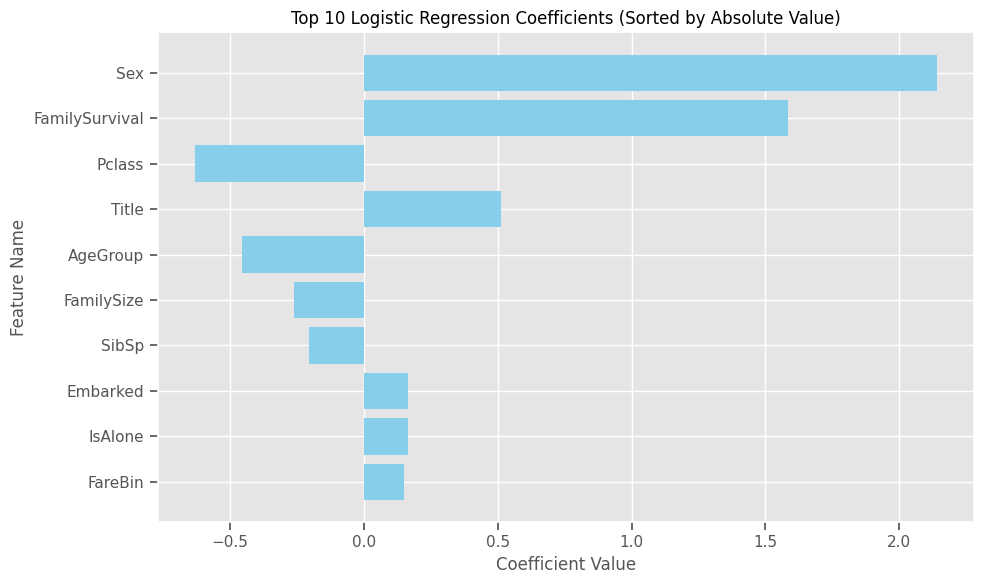

In [16]:
# Step 1: Extract coefficients and corresponding feature names
coefficients = logreg.coef_[0]
feature_names = X.columns

# Step 2: Pair coefficients with feature names and sort by absolute value
coef_feature_pairs = sorted(
    zip(coefficients, feature_names), 
    key=lambda x: abs(x[0]), 
    reverse=True
)

# Step 3: Extract the top 10 features and coefficients
top_ten_features = coef_feature_pairs[:10]
sorted_coefficients, sorted_feature_names = zip(*top_ten_features)

# Step 4: Visualize the top 10 coefficients
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_coefficients, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Top 10 Logistic Regression Coefficients (Sorted by Absolute Value)')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest coefficient on top
plt.tight_layout()  # Adjust layout for better visualization
plt.show()

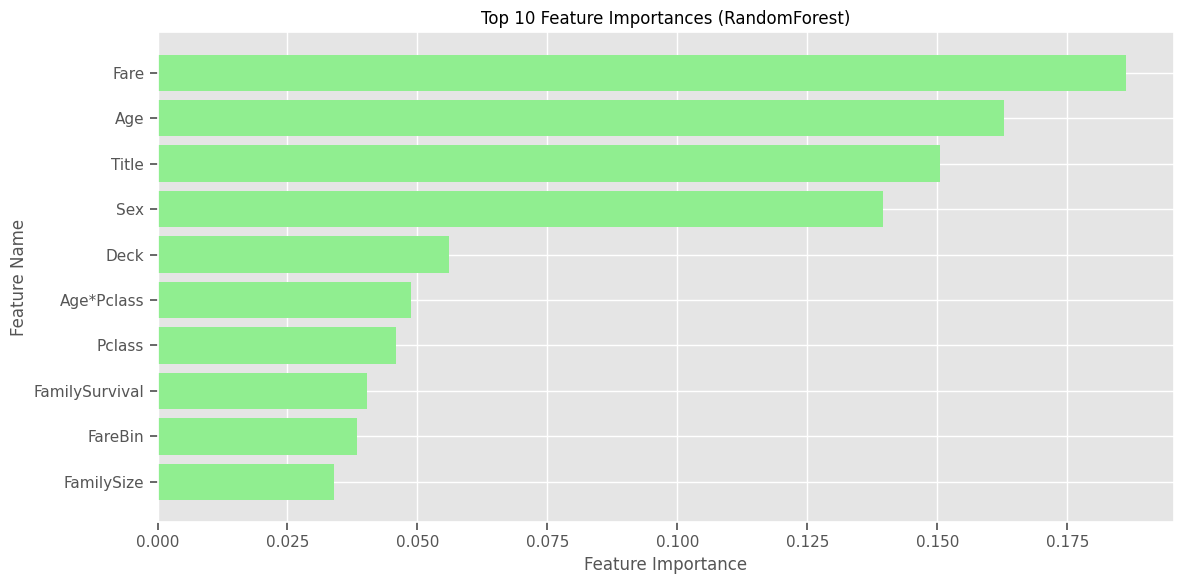

In [23]:
# Step 1: Extract feature importances and create a DataFrame
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Step 2: Select the top N features
top_n = 10
top_features = feature_importance_df.head(top_n)

# Step 3: Visualize the top N feature importances
plt.figure(figsize=(12, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='lightgreen', align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title(f'Top {top_n} Feature Importances (RandomForest)')
plt.gca().invert_yaxis()  # Highest importance on top
plt.tight_layout()  # Adjust layout for better visualization
plt.show()


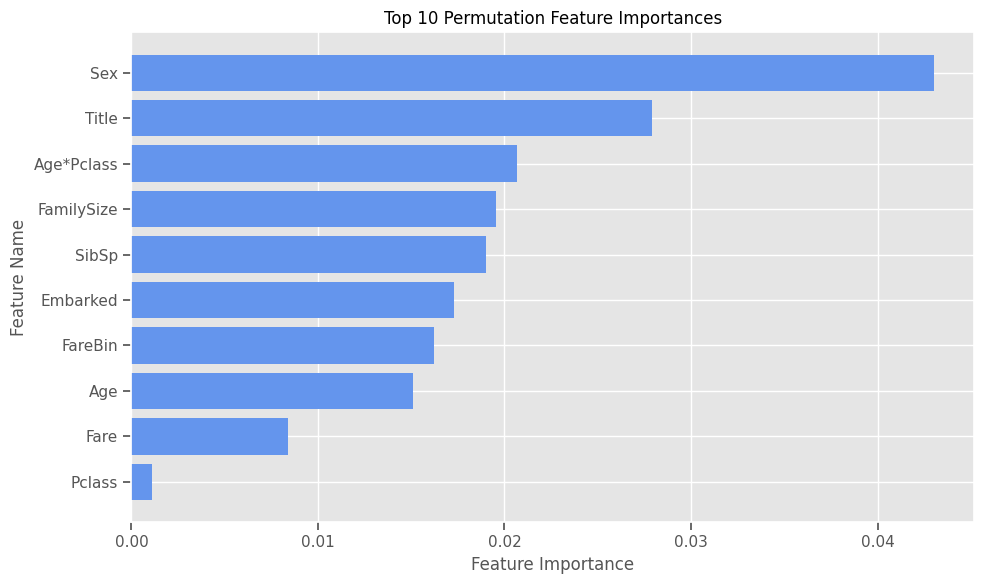

In [30]:
# Step 1: Compute Permutation Importances
perm_importance = permutation_importance(mlp, X_val, y_val, n_repeats=10, random_state=42)

# Step 2: Extract and sort feature importances
feature_importances = perm_importance.importances_mean
sorted_idx = feature_importances.argsort()[::-1]  # Indices of features sorted by importance (descending)
top_n = 10  # Number of top features to display

# Step 3: Select top N features and their names
top_features = [X.columns[i] for i in sorted_idx[:top_n]]
top_importances = feature_importances[sorted_idx[:top_n]]

# Step 4: Visualize Top N Permutation Importances
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances, color='cornflowerblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title(f"Top {top_n} Permutation Feature Importances")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Prediction Probabilities for the First Observation: [0.84 0.16]


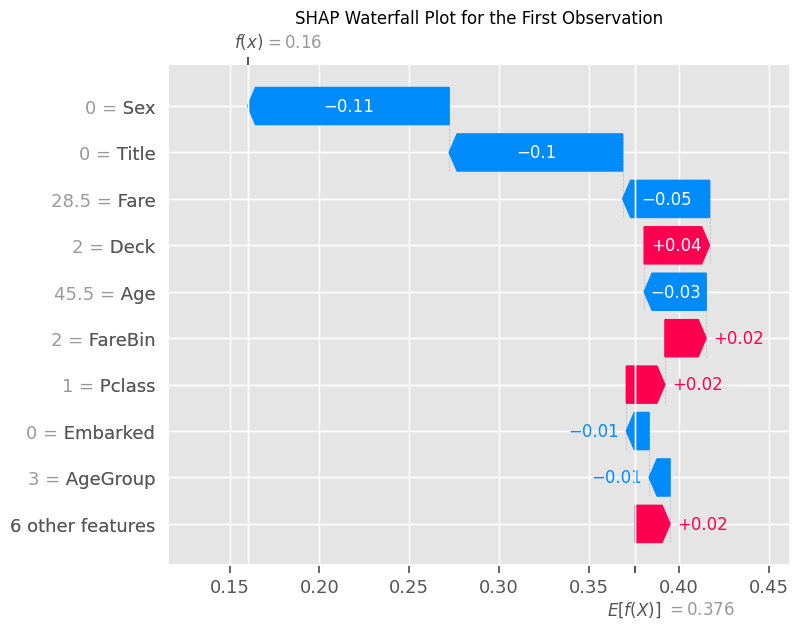

In [35]:
# Step 1: Initialize the SHAP Explainer for the RandomForest model
explainer = shap.Explainer(rf)

# Step 2: Compute SHAP values
shap_values = explainer(X_train)

# Step 3: Display model prediction probabilities for the first observation
first_observation_proba = rf.predict_proba([X_train.iloc[0]])[0]
print(f"Prediction Probabilities for the First Observation: {first_observation_proba}")

# Step 4: Generate a SHAP Waterfall Plot for the first observation
plt.title("SHAP Waterfall Plot for the First Observation")
shap.plots.waterfall(shap_values[0, :, 1])  # SHAP values for the class of interest (e.g., class 1 for survival)

# Task 11: Submission Preparation

In [ ]:
# Step 1: Preparing the test set for prediction
# Ensure that the test set has the same feature columns as the training set (after preprocessing)
X_test = test_df.drop(columns=['PassengerId'])  # PassengerId will be used in the submission, so we drop it for prediction

In [ ]:
# Step 2: Using the best model (XGBoost in this case) to make predictions on the test set
# You can replace `best_xgb` with `best_logreg` or `best_rf` if another model performed better during evaluation
final_model = stack_model  # or best_rf, or best_logreg based on your selection
y_test_pred = final_model.predict(X_test)

In [ ]:
# Step 3: Preparing the submission file
# Kaggle requires submission to have two columns: 'PassengerId' and 'Survived'
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_test_pred
})

# Save the submission file as a CSV
submission_file = 'submission.csv'
submission.to_csv(submission_file, index=False)

print(f"Submission file '{submission_file}' successfully created!")